<a href="https://colab.research.google.com/github/Series-Parallel/Machine_in_Deep_Learning/blob/main/FCN_from_scratch_to_understand_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
vgg = models.vgg16(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 75.9MB/s]


In [3]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
class FCN32s(nn.Module):
    def __init__(self, num_classes=21):
        super(FCN32s, self).__init__()

        # 1️⃣ Use VGG feature extractor
        self.features = vgg.features

        # 2️⃣ Convert fully connected layers to convolution layers
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=7)
        self.fc7 = nn.Conv2d(4096, 4096, kernel_size=1)

        # 3️⃣ Final 1x1 convolution for class prediction
        self.score = nn.Conv2d(4096, num_classes, kernel_size=1)

        # 4️⃣ Upsampling layer (32x)
        self.upscore = nn.ConvTranspose2d(
            num_classes, num_classes,
            kernel_size=64,
            stride=32,
            padding=16,
            bias=False
        )

    def forward(self, x):
        x = self.features(x)

        x = self.fc6(x)
        x = F.relu(x)

        x = self.fc7(x)
        x = F.relu(x)

        x = self.score(x)

        x = self.upscore(x)

        return x



In [15]:
model = FCN32s(num_classes=3).to(device)

In [11]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
          center = factor - 1
        else:
          center = factor - 0.5

        og = torch.arange(kernel_size).float()
        filt = (1 - torch.abs(og - center) / factor)

        weight = torch.zeros(in_channels, out_channels, kernel_size, kernel_size)

        for i in range(in_channels):
          weight[i, i] = filt.unsqueeze(0) * filt.unsqueeze(1)

        return weight

In [6]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = model(dummy_input)

print("Output shape:", output.shape)

Output shape: torch.Size([1, 21, 32, 32])


## Bilinear Initialization

In [16]:
model.upscore.weight.data.copy_(
    bilinear_kernel(3, 3, 64)
)

tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

## Load Oxford-IIIT Pet and train the model


In [14]:
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from torch.utils.data import DataLoader

transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
])

train_dataset = OxfordIIITPet(
    root="./data",
    split="trainval",
    target_types="segmentation",
    download=True,
    transform=transform_image,
    target_transform=transform_mask
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

100%|██████████| 792M/792M [00:36<00:00, 21.5MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.3MB/s]


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [19]:
model.train()

for epoch in range(1):
    for images, masks in train_loader:
        images = images.to(device)

        # Convert mask to Long and shift labels to start from 0
        masks = masks.squeeze(1).long() - 1
        masks = masks.to(device)

        outputs = model(images)

        # Fix: Resize outputs to match the mask spatial dimensions (224, 224)
        if outputs.shape[-2:] != masks.shape[-2:]:
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print("Loss:", loss.item())
        break

Loss: 1.0978196859359741


## Visualize


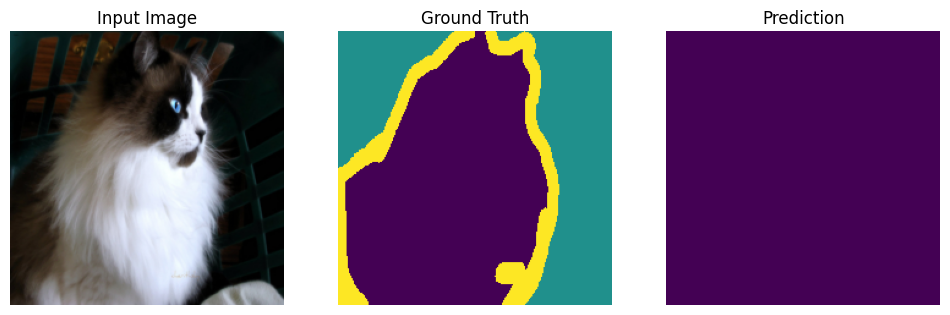

In [20]:
import matplotlib.pyplot as plt

model.eval()
images, masks = next(iter(train_loader))

images = images.to(device)
masks = masks.squeeze(1).long() - 1

with torch.no_grad():
    outputs = model(images)

pred = torch.argmax(outputs, dim=1)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(images[0].permute(1,2,0).cpu())
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(masks[0])
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred[0].cpu())
plt.title("Prediction")
plt.axis("off")

plt.show()

the training of the model was only for 1 iteration thats why we got this prediction! I think more training will show us nice predictions!

## Freeze Early Layers (Stabilize Training)

In [21]:
for param in model.features.parameters():
    param.requires_grad = False

In [22]:
optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    momentum=0.9
)

In [23]:
model.train()

for epoch in range(3):
    for i, (images, masks) in enumerate(train_loader):

        images = images.to(device)
        # Convert mask to Long and shift labels to start from 0
        masks = masks.squeeze(1).long() - 1
        masks = masks.to(device)

        outputs = model(images)

        # Fix: Resize outputs to match the mask spatial dimensions (224, 224)
        if outputs.shape[-2:] != masks.shape[-2:]:
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, Step {i}, Loss: {loss.item():.4f}")

        if i == 50:
            break

Epoch 0, Step 0, Loss: 1.0806
Epoch 0, Step 10, Loss: 1.0013
Epoch 0, Step 20, Loss: 0.9176
Epoch 0, Step 30, Loss: 0.8834
Epoch 0, Step 40, Loss: 0.8820
Epoch 0, Step 50, Loss: 0.9410
Epoch 1, Step 0, Loss: 1.0208
Epoch 1, Step 10, Loss: 1.0019
Epoch 1, Step 20, Loss: 0.8953
Epoch 1, Step 30, Loss: 0.9943
Epoch 1, Step 40, Loss: 0.8728
Epoch 1, Step 50, Loss: 0.9859
Epoch 2, Step 0, Loss: 1.0300
Epoch 2, Step 10, Loss: 1.0156
Epoch 2, Step 20, Loss: 1.0255
Epoch 2, Step 30, Loss: 0.9077
Epoch 2, Step 40, Loss: 0.9759
Epoch 2, Step 50, Loss: 0.9282


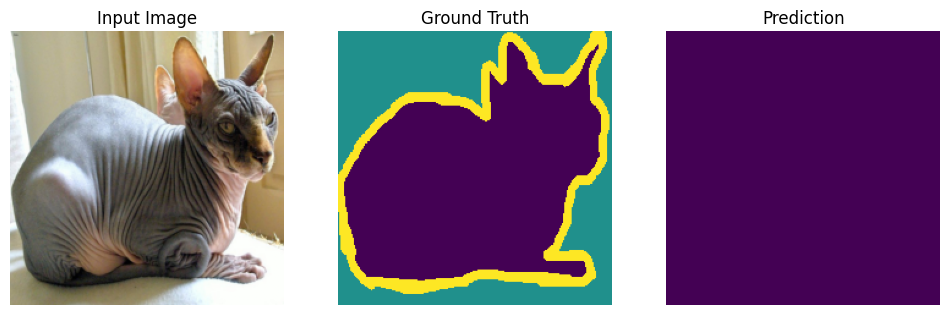

In [25]:
import matplotlib.pyplot as plt

model.eval()
images, masks = next(iter(train_loader))

images = images.to(device)
masks = masks.squeeze(1).long() - 1

with torch.no_grad():
    outputs = model(images)

pred = torch.argmax(outputs, dim=1)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(images[0].permute(1,2,0).cpu())
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(masks[0])
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred[0].cpu())
plt.title("Prediction")
plt.axis("off")

plt.show()